In [ ]:
import torch
import torchvision
import string
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [ ]:

batch_size = 256
learning_rate = 1e-5

input_size = 28*28
num_classes = 26

Let's load the training and testing dataset

In [ ]:
import os
dataset = pd.read_csv('/content/sign_mnist_train.csv')
testdataset = pd.read_csv('/content/sign_mnist_test.csv')
num_rows = dataset.shape[0]
# To map each label number to its corresponding letter
letters = dict(enumerate(string.ascii_uppercase))

In [ ]:
dataset.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
def dataframe_to_array(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1.iloc[:, 1:].to_numpy()
    targets_array = dataframe1['label'].to_numpy()
    return inputs_array, targets_array

In [ ]:
inputs_array, targets_array = dataframe_to_array(dataset)
testinputs_array, testtargets_array = dataframe_to_array(testdataset)

Letter:  D


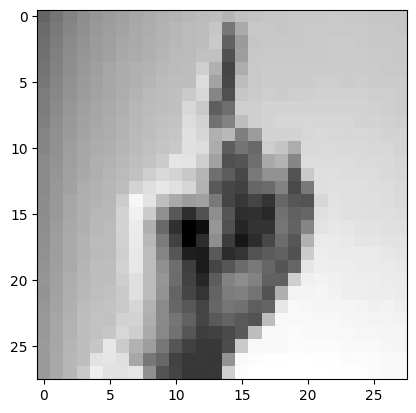

In [ ]:
pic1 = np.reshape(inputs_array[0], (28, 28))
plt.imshow(pic1, cmap = "gray")
print("Letter: ", letters[targets_array[0].item()])

In [ ]:
inputs = torch.from_numpy(inputs_array).float()
targets = torch.from_numpy(targets_array).long()
testinputs = torch.from_numpy(testinputs_array).float()
testtargets = torch.from_numpy(testtargets_array).long()

In [ ]:
# Training validation & test dataset
dataset = TensorDataset(inputs, targets)
testdataset = TensorDataset(testinputs, testtargets)

# Let's use 15% of our training dataset to validate our model
val_percent = 0.15
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(testdataset, batch_size*2)

Letter:  X


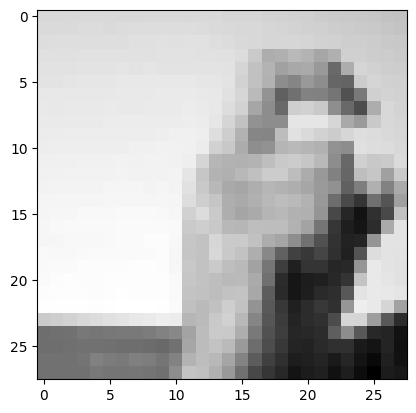

In [ ]:
img, label = train_ds[0]
plt.imshow(img.reshape((28,28)), cmap = 'gray')
print("Letter: ", letters[label.item()])

In [ ]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

model = MnistModel()

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
evaluate(model, val_loader)

{'val_loss': 167.3600311279297, 'val_acc': 0.05896874517202377}

In [ ]:
history = fit(50, 1e-4, model, train_loader, val_loader)

Epoch [0], val_loss: nan, val_acc: 0.0377
Epoch [1], val_loss: nan, val_acc: 0.0377
Epoch [2], val_loss: nan, val_acc: 0.0377
Epoch [3], val_loss: nan, val_acc: 0.0377
Epoch [4], val_loss: nan, val_acc: 0.0377
Epoch [5], val_loss: nan, val_acc: 0.0377
Epoch [6], val_loss: nan, val_acc: 0.0377
Epoch [7], val_loss: nan, val_acc: 0.0377
Epoch [8], val_loss: nan, val_acc: 0.0377
Epoch [9], val_loss: nan, val_acc: 0.0377
Epoch [10], val_loss: nan, val_acc: 0.0377
Epoch [11], val_loss: nan, val_acc: 0.0377
Epoch [12], val_loss: nan, val_acc: 0.0377
Epoch [13], val_loss: nan, val_acc: 0.0377
Epoch [14], val_loss: nan, val_acc: 0.0377
Epoch [15], val_loss: nan, val_acc: 0.0377
Epoch [16], val_loss: nan, val_acc: 0.0377
Epoch [17], val_loss: nan, val_acc: 0.0377
Epoch [18], val_loss: nan, val_acc: 0.0377
Epoch [19], val_loss: nan, val_acc: 0.0377
Epoch [20], val_loss: nan, val_acc: 0.0377
Epoch [21], val_loss: nan, val_acc: 0.0377
Epoch [22], val_loss: nan, val_acc: 0.0377


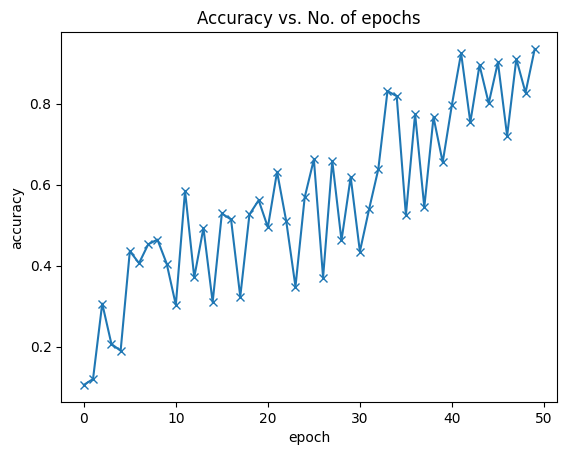

In [ ]:
# Visualizing how our model performed after each epoch
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [ ]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 13.358087539672852, 'val_acc': 0.670703113079071}

In [ ]:
model_2 = MnistModel()

In [ ]:
# Evaluating the model prior to training
evaluate(model_2, val_loader)

{'val_loss': 136.73118591308594, 'val_acc': 0.04519807547330856}

In [ ]:
history_2 = fit(50, 1e-5, model_2, train_loader, val_loader)

Epoch [0], val_loss: 34.2106, val_acc: 0.0647
Epoch [1], val_loss: 30.3715, val_acc: 0.1030
Epoch [2], val_loss: 21.2485, val_acc: 0.1512
Epoch [3], val_loss: 17.9354, val_acc: 0.2232
Epoch [4], val_loss: 17.1045, val_acc: 0.2409
Epoch [5], val_loss: 16.3457, val_acc: 0.2602
Epoch [6], val_loss: 13.3117, val_acc: 0.3029
Epoch [7], val_loss: 13.1047, val_acc: 0.3093
Epoch [8], val_loss: 11.2722, val_acc: 0.3127
Epoch [9], val_loss: 12.0028, val_acc: 0.3219
Epoch [10], val_loss: 10.8905, val_acc: 0.3704
Epoch [11], val_loss: 10.9672, val_acc: 0.3456
Epoch [12], val_loss: 11.0827, val_acc: 0.3425
Epoch [13], val_loss: 8.9765, val_acc: 0.4044
Epoch [14], val_loss: 9.2336, val_acc: 0.3801
Epoch [15], val_loss: 8.4721, val_acc: 0.4007
Epoch [16], val_loss: 8.1288, val_acc: 0.4129
Epoch [17], val_loss: 8.6172, val_acc: 0.4437
Epoch [18], val_loss: 7.7629, val_acc: 0.4559
Epoch [19], val_loss: 7.5904, val_acc: 0.4543
Epoch [20], val_loss: 5.5180, val_acc: 0.4986
Epoch [21], val_loss: 6.2900, v

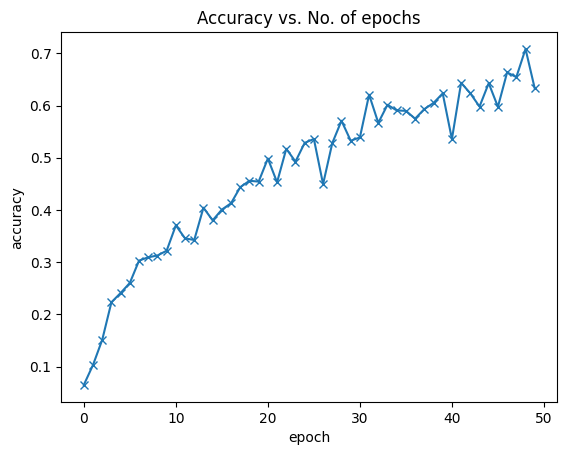

In [ ]:
# Visualizing how our model performed after each epoch
accuracies_2 = [r['val_acc'] for r in history_2]
plt.plot(accuracies_2, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [ ]:
history_3 = fit(50, 1e-5, model_2, train_loader, val_loader)

NameError: name 'fit' is not defined

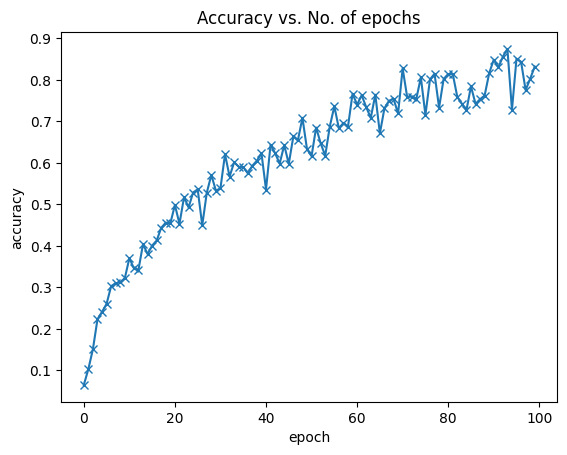

In [ ]:
# Visualizing total performance of the model across 100 epoch
accuracies_3 = [r['val_acc'] for r in history_3]
accuracies_model2 = accuracies_2 + accuracies_3
plt.plot(accuracies_model2, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [ ]:
# Evaluate on test dataset
result_2 = evaluate(model_2, test_loader)
result_2

{'val_loss': 6.07506799697876, 'val_acc': 0.5463541746139526}

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: H , Predicted: H


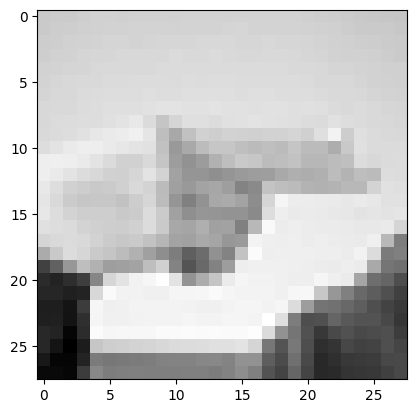

In [ ]:
img, label = testdataset[919]
plt.imshow(img.reshape(28,28), cmap='gray')
print('Label:', letters[label.item()], ', Predicted:', letters[predict_image(img, model_2)])

Label: H , Predicted: H


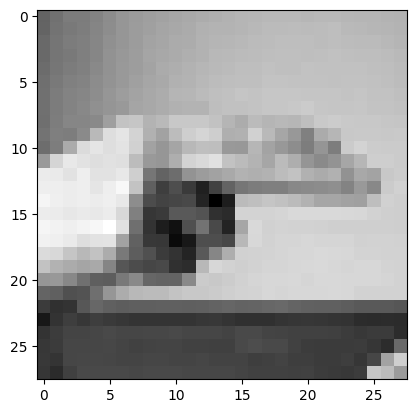

In [ ]:
img, label = testdataset[19]
plt.imshow(img.reshape(28,28), cmap='gray')
print('Label:', letters[label.item()], ', Predicted:', letters[predict_image(img, model_2)])

In [ ]:
# Here the model parameters are saved so that we dont have to train the model next time
torch.save(model_2.state_dict(), 'mnist-logistic.pth')

In [ ]:
# Let's look at the model parameters
model_2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0240,  0.0300, -0.0241,  ...,  0.0305,  0.0084,  0.0169],
                      [ 0.0292, -0.0224,  0.0213,  ...,  0.0163,  0.0182, -0.0221],
                      [ 0.0208,  0.0135,  0.0022,  ...,  0.0256,  0.0067,  0.0235],
                      ...,
                      [-0.0225, -0.0001, -0.0187,  ..., -0.0074,  0.0165,  0.0044],
                      [ 0.0020, -0.0117, -0.0293,  ...,  0.0065, -0.0170,  0.0202],
                      [-0.0357, -0.0287, -0.0272,  ..., -0.0332,  0.0141,  0.0133]])),
             ('linear.bias',
              tensor([ 0.0279, -0.0096,  0.0236,  0.0202,  0.0165,  0.0007, -0.0170,  0.0072,
                       0.0340,  0.0248, -0.0117, -0.0034, -0.0095, -0.0198,  0.0221,  0.0160,
                      -0.0350,  0.0281, -0.0002,  0.0185, -0.0165,  0.0301,  0.0176,  0.0278,
                      -0.0315,  0.0196]))])

In [ ]:
# To verify we can load these parameters in a new model
model_3 = MnistModel()
model_3.load_state_dict(torch.load('mnist-logistic.pth'))
model_3.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0240,  0.0300, -0.0241,  ...,  0.0305,  0.0084,  0.0169],
                      [ 0.0292, -0.0224,  0.0213,  ...,  0.0163,  0.0182, -0.0221],
                      [ 0.0208,  0.0135,  0.0022,  ...,  0.0256,  0.0067,  0.0235],
                      ...,
                      [-0.0225, -0.0001, -0.0187,  ..., -0.0074,  0.0165,  0.0044],
                      [ 0.0020, -0.0117, -0.0293,  ...,  0.0065, -0.0170,  0.0202],
                      [-0.0357, -0.0287, -0.0272,  ..., -0.0332,  0.0141,  0.0133]])),
             ('linear.bias',
              tensor([ 0.0279, -0.0096,  0.0236,  0.0202,  0.0165,  0.0007, -0.0170,  0.0072,
                       0.0340,  0.0248, -0.0117, -0.0034, -0.0095, -0.0198,  0.0221,  0.0160,
                      -0.0350,  0.0281, -0.0002,  0.0185, -0.0165,  0.0301,  0.0176,  0.0278,
                      -0.0315,  0.0196]))])